In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, ParameterGrid, KFold
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.7.0'

### MLP module

In [ ]:
class MLP(object):
    def __init__(self, input_size, output_size, hidden_size=1024, device=None):
        """
        input_size: int, size of input layer
        output_size: int, size of output layer
        hidden_size: int, size of hidden layer
        device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Execution
        """
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.device = device
 
        # Initialize weights for input layer
        self.W1 = tf.Variable(tf.random.normal([self.input_size, self.hidden_size]))
        self.b1 = tf.Variable(tf.random.normal([1, self.hidden_size]))

        # Initialize weights for the first hidden layer
        self.W12 = tf.Variable(tf.random.normal([self.hidden_size, self.hidden_size]))
        self.b12 = tf.Variable(tf.random.normal([1, self.hidden_size]))

        # Initialize weights between the first hidden layer and the second hidden layer
        self.W22 = tf.Variable(tf.random.normal([self.hidden_size, self.hidden_size]))
        self.b22 = tf.Variable(tf.random.normal([1, self.hidden_size]))

        # Initialize weights between the second hidden layer and the output layer
        self.W2 = tf.Variable(tf.random.normal([self.hidden_size, self.output_size]))
        self.b2 = tf.Variable(tf.random.normal([1, self.output_size]))

        # define variables to be updated during backpropagation
        self.variables = [self.W1, self.W12, self.W22, self.W2, self.b1, self.b12, self.b22, self.b2]

    
    def forward(self, X, dropout=0.0):
        """ Forward pass
        X: tensor, inputs
        """
        if self.device is not None:
            with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
                self.y = self.compute_output(X, dropout)
        else:
            self.y = self.compute_output(X, dropout)
        
        return self.y
    
    def loss(self, y_pred, y_true, beta=0.0):
        """
        y_pred: tensor of shape (batch_size, output_size),
        y_true: tensor of shape (batch_size), true labels are provided as integers
        beta: weight of penalty term
        """
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        y_true_tf = tf.cast(y_true, dtype=tf.int32)
        cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_tf, logits=y_pred_tf))
        l2_penalty = tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W12) + tf.nn.l2_loss(self.W2)
        total_cost = cost + beta * l2_penalty

        return total_cost
    
    def backward(self, X_train, y_train, dropout=0.0, beta=0.0, lr=1e-6):
        """
        backward pass
        X_train: tensor of shape (batch_size, input_size)
        y_train: tensor of shape (batch_size)
        dropout:
        beta:
        lr:
        """
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

        with tf.GradientTape() as tape:
            predicted = self.forward(X_train, dropout=dropout)
            current_loss = self.loss(predicted, y_train,beta=beta)
        grads = tape.gradient(current_loss, self.variables)
        optimizer.apply_gradients(zip(grads, self.variables))

        return predicted, current_loss, grads
    
    def compute_output(self, X, dropout):
        """Custom method to obtain output tensor during forward pass
        X: tensor, input
        dropout: dropout rate
        """

        # Cast X to float32
        X_tf = tf.cast(X, dtype=tf.float32)

        # compute values in the input layer
        logits1 = tf.matmul(X_tf, self.W1) + self.b1
        input_layer = tf.nn.relu(logits1)

        # compute values in the first hidden layer
        logits12 = tf.matmul(input_layer, self.W12) + self.b12
        hidden_layer1 = tf.nn.relu(logits12)
        # hidden_layer1_dropout = tf.nn.dropout(hidden_layer1, rate=dropout_rate, seed=1)
        hidden_layer1_dropout = tf.nn.experimental.stateless_dropout(hidden_layer1, rate=dropout, seed=[0,1])

        # compute values in the second hidden layer
        logits22 = tf.matmul(hidden_layer1_dropout, self.W22) + self.b22
        hidden_layer2 = tf.nn.relu(logits22)
        # hidden_layer2_dropout = tf.nn.dropout(hidden_layer2, rate = dropout_rate, seed = 2)
        hidden_layer2_dropout = tf.nn.experimental.stateless_dropout(hidden_layer2, rate=dropout, seed=[1,2])

        # compute values in the output layer
        output = tf.matmul(hidden_layer2_dropout, self.W2) + self.b2
        return output


In [ ]:
def load_data(dataset='fashion_mnist', valid_size=0.2):
    if dataset == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    elif dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    else:
        print("invalid dataset")
        return
   
    # scale data to the range of [0,1]
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    x_train_tf = tf.reshape(x_train, (x_train.shape[0], -1))
    x_test_tf = tf.reshape(x_test, (x_test.shape[0], -1))
    
    return x_train_tf, y_train, x_test_tf, y_test


def accuracy(predictions, labels):
    preds = tf.argmax(predictions, axis=1).numpy()
    acc = np.sum(preds == labels) / predictions.shape[0]
    return 100.0* acc


def train(model, x_train_tf, y_train, x_validation_tf, y_validation, 
          batch_size=128, 
          dropout_rate=0.0, 
          beta=0.0, 
          learning_rate=1e-5, 
          epochs=30):
    
    epoch = 0
    global_step = 0
    eval_steps = 100
    train_data_size, validation_data_size = x_train_tf.shape[0], x_validation_tf.shape[0]

    train_losses = []
    eval_losses = []
    train_accuracy = []
    eval_accuracy = []

    while epoch < epochs:
        epoch += 1
        # Split dataset into batches
        train_ds = tf.data.Dataset.from_tensor_slices((x_train_tf, y_train)).shuffle(train_data_size, 
                                                                                 seed=epoch*(1234)).batch(batch_size)
        
        for inputs, outputs in train_ds:
            train_preds, train_loss, _ = model.backward(inputs, outputs, dropout=dropout_rate, lr=learning_rate, beta=beta)

            global_step += 1
            if global_step % eval_steps == 0:
                train_losses.append(train_loss)
                train_acc = accuracy(tf.nn.softmax(train_preds), outputs)
                train_accuracy.append(train_acc)

                # evaluation
                eval_preds = model.forward(x_validation_tf, dropout=0.0)
                eval_loss = model.loss(eval_preds, y_validation, beta=0.0)
                eval_acc = accuracy(tf.nn.softmax(eval_preds), y_validation)
                
                eval_losses.append(eval_loss)
                eval_accuracy.append(eval_acc)
                print('Epoch={}, Steps={} - Average Train Loss:={}, Average Evaluation Loss:={}, Train Batch Acc:={}, Evaluation Acc:={}'.format(epoch, global_step, train_loss, eval_loss, train_acc, eval_acc))
    
    return model, train_losses, eval_losses, train_accuracy, eval_accuracy

def test(model, x_test_tf, y_test):
    test_preds = model.forward(x_test_tf, dropout=0.0)
    test_acc = accuracy(tf.nn.softmax(test_preds), y_test)
    return test_acc


### visualize data samples

4431872/4422102 [==============================] - 0s 0us/step
sample image shape: (28, 28)
sample image label: 9


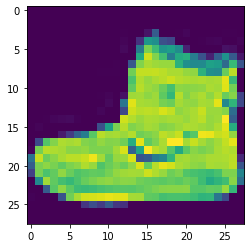

In [ ]:
train_x, train_y, test_x, test_y = load_data(dataset="fashion_mnist")
sample = tf.reshape(train_x[0], (28,28))
print(f"sample image shape: {sample.shape}")
print(f"sample image label: {train_y[0]}")
plt.imshow(sample)

### Model1: without any regularization

#### obtain a baseline accuracy with default hyperparameters configuration.

In [ ]:
image_size = 28
input_size = image_size * image_size
output_size = 10

x_train, y_train, x_test, y_test = load_data(dataset="fashion_mnist")
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

baseline_mlp = MLP(input_size, output_size)
baseline_mlp, train_losses, eval_losses, train_accuracy, eval_accuracy = train(baseline_mlp, x_train, y_train, x_test, y_test)

x_train shape: (60000, 784)
x_test shape: (10000, 784)
Epoch=1, Steps=100 - Average Train Loss:=18005.65234375, Average Evaluation Loss:=16900.056640625, Train Batch Acc:=67.96875, Evaluation Acc:=64.05
Epoch=1, Steps=200 - Average Train Loss:=8934.9228515625, Average Evaluation Loss:=13026.6240234375, Train Batch Acc:=78.125, Evaluation Acc:=70.50999999999999
Epoch=1, Steps=300 - Average Train Loss:=10809.66796875, Average Evaluation Loss:=12351.73828125, Train Batch Acc:=76.5625, Evaluation Acc:=71.8
Epoch=1, Steps=400 - Average Train Loss:=9892.763671875, Average Evaluation Loss:=12357.2763671875, Train Batch Acc:=77.34375, Evaluation Acc:=70.39
Epoch=2, Steps=500 - Average Train Loss:=8387.97265625, Average Evaluation Loss:=9262.4052734375, Train Batch Acc:=75.0, Evaluation Acc:=75.03999999999999
Epoch=2, Steps=600 - Average Train Loss:=12591.890625, Average Evaluation Loss:=10611.4755859375, Train Batch Acc:=69.53125, Evaluation Acc:=73.59
Epoch=2, Steps=700 - Average Train Loss:=

baseline test accuracy

In [ ]:
baseline_accuracy = test(baseline_mlp, x_test, y_test)
print(baseline_accuracy)

82.28999999999999


learning curve

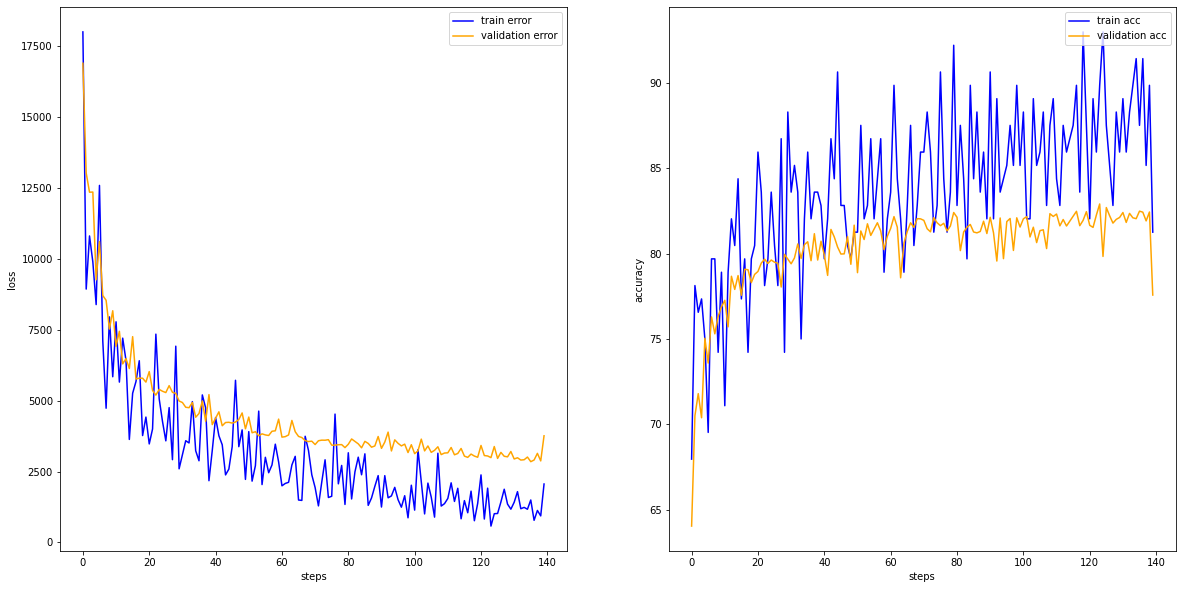

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20, 10))
axs[0].plot(train_losses, label="train error", color='blue')
axs[0].plot(eval_losses, label="validation error", color='orange')
axs[0].set_xlabel("steps")
axs[0].set_ylabel("loss")
axs[0].legend(loc="upper right")

axs[1].plot(train_accuracy, label="train acc", color="blue")
axs[1].plot(eval_accuracy, label="validation acc", color='orange')
axs[1].set_xlabel("steps")
axs[1].set_ylabel("accuracy")
axs[1].legend(loc="upper right")

plt.show()

#### hyperparameter tuning

In [ ]:
input_size = 28 * 28
output_size = 10

hidden_size = [512, 1024]
learning_rate = [1e-4, 1e-5]
batch_size = [32, 128]
epochs = [10, 20]


grid = dict(
    hidden_size = hidden_size,
    learning_rate = learning_rate,
    batch_size = batch_size,
    epochs = epochs
)

x_train_tf, y_train_tf, x_test_tf, y_test_tf = load_data(dataset='fashion_mnist')

print("performing grid search...")
params_grid = list(ParameterGrid(grid))

test_accuracy = []
for params in params_grid:
    print(f"current parameters: {params}")
    kf = KFold(n_splits=5, random_state=12, shuffle=True)
    acc = []

    for train_index, validation_index in kf.split(x_train_tf):
        train_indices = np.reshape(train_index, (len(train_index), -1))
        validation_indices = np.reshape(validation_index, (len(validation_index), -1))

        x_train = tf.gather_nd(x_train_tf, indices=train_indices)
        x_validation = tf.gather_nd(x_train_tf, indices=validation_indices)

        y_train, y_validation = y_train_tf[train_index], y_train_tf[validation_index]

        print(f"x_train shape: {x_train.shape}")
        print(f"x_validation shape: {x_validation.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"y_validation shape: {y_validation.shape}")

        mlp = MLP(input_size, output_size, params['hidden_size'])
        mlp, _, _, _, _ = train(mlp, x_train, y_train, x_validation, y_validation,
                    batch_size = params['batch_size'], 
                    learning_rate = params['learning_rate'], 
                    epochs = params['epochs'])
        _acc = test(mlp, x_validation, y_validation)
        acc.append(_acc)
    
    test_accuracy.append(np.mean(acc))

pos = test_accuracy.index(max(test_accuracy))
best_params = params_grid[pos]
print(f"best parameters: {best_params}")


Streaming output truncated to the last 5000 lines.
Epoch=10, Steps=14300 - Average Train Loss:=42.53807830810547, Average Evaluation Loss:=433.3238830566406, Train Batch Acc:=84.375, Evaluation Acc:=81.625
Epoch=10, Steps=14400 - Average Train Loss:=45.91133117675781, Average Evaluation Loss:=436.5981750488281, Train Batch Acc:=90.625, Evaluation Acc:=81.79166666666666
Epoch=10, Steps=14500 - Average Train Loss:=56.515220642089844, Average Evaluation Loss:=434.0694885253906, Train Batch Acc:=84.375, Evaluation Acc:=81.375
Epoch=10, Steps=14600 - Average Train Loss:=88.0861587524414, Average Evaluation Loss:=432.0621337890625, Train Batch Acc:=87.5, Evaluation Acc:=81.27499999999999
Epoch=10, Steps=14700 - Average Train Loss:=45.520538330078125, Average Evaluation Loss:=430.3478698730469, Train Batch Acc:=84.375, Evaluation Acc:=81.2
Epoch=10, Steps=14800 - Average Train Loss:=19.23517608642578, Average Evaluation Loss:=434.76422119140625, Train Batch Acc:=93.75, Evaluation Acc:=80.6333

use best parameters to train model and then test

In [ ]:
mlp = MLP(input_size, output_size, best_params['hidden_size'])
mlp, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = best_params['batch_size'], 
            learning_rate = best_params['learning_rate'], 
            epochs = best_params['epochs'])

test_acc = test(mlp, x_test_tf, y_test_tf)
print(f"with best parameters, the test accuracy={test_acc}")

Epoch=1, Steps=100 - Average Train Loss:=18188.166015625, Average Evaluation Loss:=18281.2890625, Train Batch Acc:=65.625, Evaluation Acc:=63.17
Epoch=1, Steps=200 - Average Train Loss:=33262.94921875, Average Evaluation Loss:=19367.96875, Train Batch Acc:=50.0, Evaluation Acc:=69.03
Epoch=1, Steps=300 - Average Train Loss:=20784.33984375, Average Evaluation Loss:=14281.08203125, Train Batch Acc:=65.625, Evaluation Acc:=70.50999999999999
Epoch=1, Steps=400 - Average Train Loss:=7265.71044921875, Average Evaluation Loss:=10648.046875, Train Batch Acc:=84.375, Evaluation Acc:=75.2
Epoch=1, Steps=500 - Average Train Loss:=7062.80859375, Average Evaluation Loss:=10471.0908203125, Train Batch Acc:=81.25, Evaluation Acc:=75.87
Epoch=1, Steps=600 - Average Train Loss:=7497.80078125, Average Evaluation Loss:=9845.44921875, Train Batch Acc:=87.5, Evaluation Acc:=76.77000000000001
Epoch=1, Steps=700 - Average Train Loss:=11260.537109375, Average Evaluation Loss:=9689.4267578125, Train Batch Acc:

learning curve

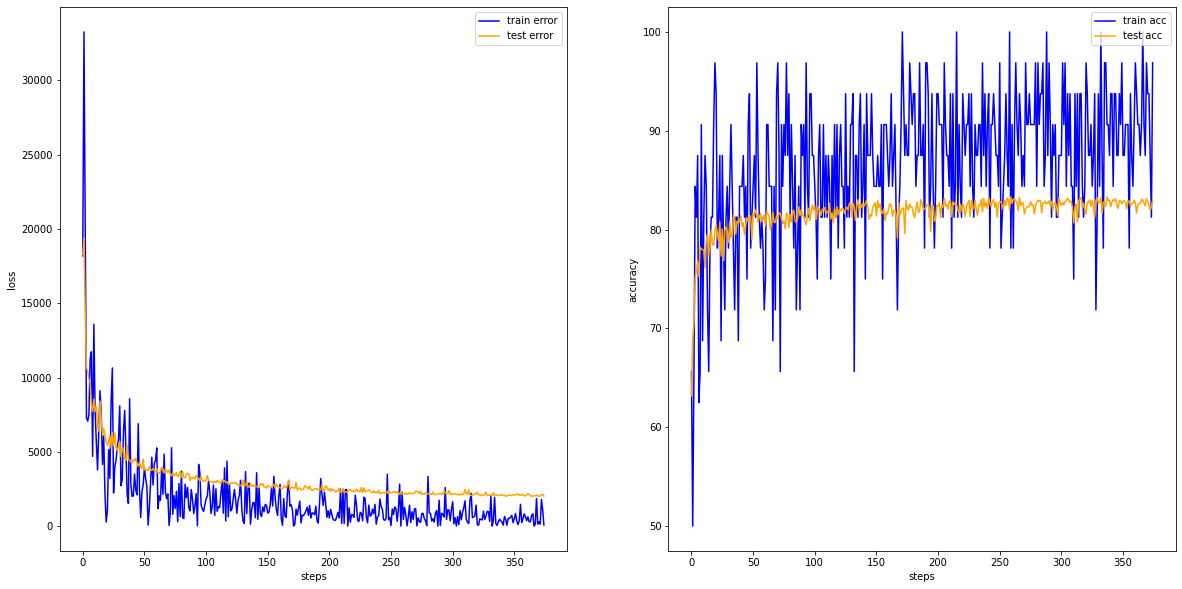

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))
axs[0].plot(train_losses, label="train error", color='blue')
axs[0].plot(eval_losses, label="test error", color='orange')
axs[0].set_xlabel("steps")
axs[0].set_ylabel("loss")
axs[0].legend(loc="upper right")

axs[1].plot(train_accuracy, label="train acc", color="blue")
axs[1].plot(test_accuracy, label="test acc", color='orange')
axs[1].set_xlabel("steps")
axs[1].set_ylabel("accuracy")
axs[1].legend(loc="upper right")

plt.show()

reporting variance

Epoch=1, Steps=100 - Average Train Loss:=11938.55078125, Average Evaluation Loss:=15794.7666015625, Train Batch Acc:=65.625, Evaluation Acc:=66.72
Epoch=1, Steps=200 - Average Train Loss:=20118.40234375, Average Evaluation Loss:=11897.7275390625, Train Batch Acc:=68.75, Evaluation Acc:=71.38
Epoch=1, Steps=300 - Average Train Loss:=21890.224609375, Average Evaluation Loss:=15645.4365234375, Train Batch Acc:=59.375, Evaluation Acc:=71.31
Epoch=1, Steps=400 - Average Train Loss:=9204.625, Average Evaluation Loss:=16350.513671875, Train Batch Acc:=75.0, Evaluation Acc:=66.47999999999999
Epoch=1, Steps=500 - Average Train Loss:=10906.7529296875, Average Evaluation Loss:=10899.4462890625, Train Batch Acc:=75.0, Evaluation Acc:=73.0
Epoch=1, Steps=600 - Average Train Loss:=10052.2763671875, Average Evaluation Loss:=10698.26953125, Train Batch Acc:=81.25, Evaluation Acc:=73.36
Epoch=1, Steps=700 - Average Train Loss:=10667.078125, Average Evaluation Loss:=8931.599609375, Train Batch Acc:=68.7

{'boxes': [<matplotlib.lines.Line2D at 0x7ff03e502550>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff03e4c9590>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff0c00eead0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff0c00ee210>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff03e5022d0>,
  <matplotlib.lines.Line2D at 0x7ff03e4c9a90>]}

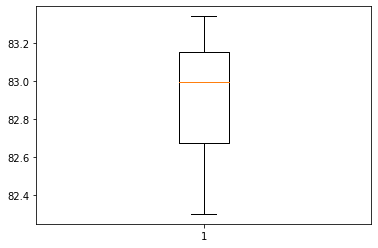

In [ ]:
best_params = {
    "hidden_size": 1024,
    "batch_size": 32,
    "learning_rate": 1e-5,
    "epochs": 20
}

accuracys = []
for i in range(1, 11):
    tf.random.set_seed(i)

    mlp = MLP(input_size, output_size, best_params['hidden_size'])
    mlp, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = best_params['batch_size'], 
            learning_rate = best_params['learning_rate'], 
            epochs = best_params['epochs'])

    test_acc = test(mlp, x_test_tf, y_test_tf)
    accuracys.append(test_acc)

mean = np.mean(accuracys)
var = np.var(accuracys)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")


{'boxes': [<matplotlib.lines.Line2D at 0x7fefb94c69d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fefb937f5d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fefb9385610>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fefb93850d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fefb9534550>,
  <matplotlib.lines.Line2D at 0x7fefb937f090>]}

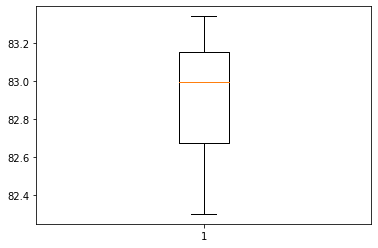

In [ ]:
plt.boxplot(accuracys)

### Model2: with dropout regularization

using cross validation to select dropout rate parameter based on previous selected hyperparameters.

In [ ]:
input_size = 28 * 28
output_size = 10

hidden_size = 1024
learning_rate = 1e-5
batch_size = 32
epochs = 20

dropout_candidates = [0.1, 0.2, 0.3]

x_train_tf, y_train_tf, x_test_tf, y_test_tf = load_data(dataset="fashion_mnist")
test_accuracy = []

for dropout in dropout_candidates:
    kf = KFold(n_splits=5, random_state=12, shuffle=True)
    acc = []

    for train_index, validation_index in kf.split(x_train_tf):
        train_indices = np.reshape(train_index, (len(train_index), -1))
        validation_indices = np.reshape(validation_index, (len(validation_index), -1))

        x_train = tf.gather_nd(x_train_tf, indices=train_indices)
        x_validation = tf.gather_nd(x_train_tf, indices=validation_indices)

        y_train, y_validation = y_train_tf[train_index], y_train_tf[validation_index]

        print(f"x_train shape: {x_train.shape}")
        print(f"x_validation shape: {x_validation.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"y_validation shape: {y_validation.shape}")

        mlp = MLP(input_size, output_size, hidden_size)
        mlp, _, _, _, _ = train(mlp, x_train, y_train, x_validation, y_validation,
                    batch_size = batch_size, 
                    learning_rate = learning_rate, 
                    epochs = epochs,
                    dropout_rate = dropout)
        _acc = test(mlp, x_validation, y_validation)
        acc.append(_acc)

    test_accuracy.append(np.mean(acc))

pos = test_accuracy.index(max(test_accuracy))
best_dropout = dropout_candidates[pos]
print(f"best dropout rate = {best_dropout}")


x_train shape: (48000, 784)
x_validation shape: (12000, 784)
y_train shape: (48000,)
y_validation shape: (12000,)
Epoch=1, Steps=100 - Average Train Loss:=37290.1875, Average Evaluation Loss:=28304.677734375, Train Batch Acc:=62.5, Evaluation Acc:=65.99166666666667
Epoch=1, Steps=200 - Average Train Loss:=41831.50390625, Average Evaluation Loss:=13271.2802734375, Train Batch Acc:=46.875, Evaluation Acc:=73.79166666666667
Epoch=1, Steps=300 - Average Train Loss:=13964.982421875, Average Evaluation Loss:=12443.4091796875, Train Batch Acc:=75.0, Evaluation Acc:=73.74166666666667
Epoch=1, Steps=400 - Average Train Loss:=16338.6669921875, Average Evaluation Loss:=10972.099609375, Train Batch Acc:=81.25, Evaluation Acc:=76.47500000000001
Epoch=1, Steps=500 - Average Train Loss:=15782.998046875, Average Evaluation Loss:=10241.34765625, Train Batch Acc:=78.125, Evaluation Acc:=77.575
Epoch=1, Steps=600 - Average Train Loss:=14623.3212890625, Average Evaluation Loss:=8872.3369140625, Train Batc

using best parameters to train the model and then test

In [ ]:
mlp2 = MLP(input_size, output_size, hidden_size)
mlp2, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp2, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = batch_size, 
            learning_rate = learning_rate, 
            epochs = epochs,
            dropout_rate = best_dropout)

test_acc = test(mlp2, x_test_tf, y_test_tf)
print(f"with best dropout rate, the test accuracy={test_acc}")

Epoch=1, Steps=100 - Average Train Loss:=30753.8828125, Average Evaluation Loss:=26692.15625, Train Batch Acc:=53.125, Evaluation Acc:=64.60000000000001
Epoch=1, Steps=200 - Average Train Loss:=19785.220703125, Average Evaluation Loss:=17271.8359375, Train Batch Acc:=65.625, Evaluation Acc:=70.94
Epoch=1, Steps=300 - Average Train Loss:=12606.9765625, Average Evaluation Loss:=15304.1728515625, Train Batch Acc:=78.125, Evaluation Acc:=72.44
Epoch=1, Steps=400 - Average Train Loss:=19572.61328125, Average Evaluation Loss:=12391.150390625, Train Batch Acc:=78.125, Evaluation Acc:=75.92999999999999
Epoch=1, Steps=500 - Average Train Loss:=21123.24609375, Average Evaluation Loss:=11641.6318359375, Train Batch Acc:=59.375, Evaluation Acc:=75.76
Epoch=1, Steps=600 - Average Train Loss:=10185.14453125, Average Evaluation Loss:=9983.8740234375, Train Batch Acc:=71.875, Evaluation Acc:=78.09
Epoch=1, Steps=700 - Average Train Loss:=15036.40625, Average Evaluation Loss:=9369.9560546875, Train Bat

learning curve

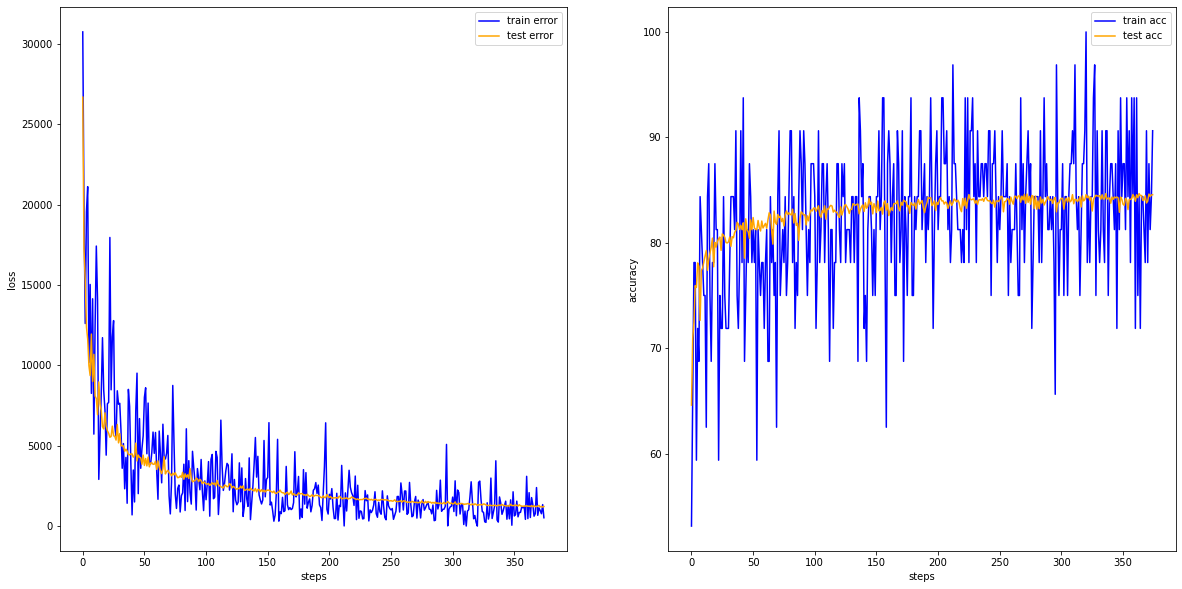

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))
axs[0].plot(train_losses, label="train error", color='blue')
axs[0].plot(eval_losses, label="test error", color='orange')
axs[0].set_xlabel("steps")
axs[0].set_ylabel("loss")
axs[0].legend(loc="upper right")

axs[1].plot(train_accuracy, label="train acc", color="blue")
axs[1].plot(test_accuracy, label="test acc", color='orange')
axs[1].set_xlabel("steps")
axs[1].set_ylabel("accuracy")
axs[1].legend(loc="upper right")

plt.show()

reporting variance

In [ ]:
hidden_size = 1024
learning_rate = 1e-5
batch_size = 32
epochs = 20
dropout = 0.1

test_accuracys = []
for i in range(3, 13):
    tf.random.set_seed(i)

    mlp = MLP(input_size, output_size, hidden_size)
    mlp, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = batch_size, 
            learning_rate = learning_rate, 
            epochs = epochs,
            dropout_rate = dropout)

    test_acc = test(mlp, x_test_tf, y_test_tf)
    test_accuracys.append(test_acc)

Epoch=1, Steps=100 - Average Train Loss:=10933.11328125, Average Evaluation Loss:=20391.248046875, Train Batch Acc:=68.75, Evaluation Acc:=66.34
Epoch=1, Steps=200 - Average Train Loss:=15109.0185546875, Average Evaluation Loss:=14508.3505859375, Train Batch Acc:=62.5, Evaluation Acc:=71.12
Epoch=1, Steps=300 - Average Train Loss:=13402.857421875, Average Evaluation Loss:=13556.0654296875, Train Batch Acc:=75.0, Evaluation Acc:=72.19
Epoch=1, Steps=400 - Average Train Loss:=8632.5712890625, Average Evaluation Loss:=13484.240234375, Train Batch Acc:=71.875, Evaluation Acc:=73.25
Epoch=1, Steps=500 - Average Train Loss:=18638.20703125, Average Evaluation Loss:=13082.4599609375, Train Batch Acc:=59.375, Evaluation Acc:=72.11
Epoch=1, Steps=600 - Average Train Loss:=14651.482421875, Average Evaluation Loss:=9968.5810546875, Train Batch Acc:=65.625, Evaluation Acc:=76.18
Epoch=1, Steps=700 - Average Train Loss:=13514.2099609375, Average Evaluation Loss:=9234.4873046875, Train Batch Acc:=71.

the mean of 10 runs is 83.98299999999999, and the variance is 0.24954099999999654


{'boxes': [<matplotlib.lines.Line2D at 0x7ff9fe216290>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff9fe21d310>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff9fe223350>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff9fe21ddd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff9fe216850>,
  <matplotlib.lines.Line2D at 0x7ff9fe216d90>]}

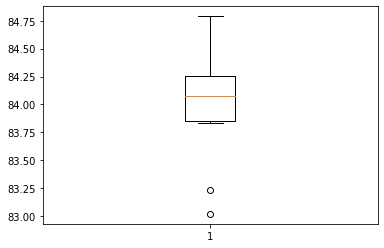

In [ ]:
mean = np.mean(test_accuracys)
var = np.var(test_accuracys)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

plt.boxplot(test_accuracys)

### Model3: with dropout and L2 regularization

using cross validation to select beta parameter

In [ ]:
input_size = 28 * 28
output_size = 10

hidden_size = 1024
learning_rate = 1e-5
batch_size = 32
epochs = 20
dropout = 0.1

beta_candidates = [0.1, 0.01, 0.001]

x_train_tf, y_train_tf, x_test_tf, y_test_tf = load_data(dataset="fashion_mnist")
test_accuracy = []

for beta in beta_candidates:
    kf = KFold(n_splits=5, random_state=1234, shuffle=True)
    acc = []

    for train_index, validation_index in kf.split(x_train_tf):
        train_indices = np.reshape(train_index, (len(train_index), -1))
        validation_indices = np.reshape(validation_index, (len(validation_index), -1))

        x_train = tf.gather_nd(x_train_tf, indices=train_indices)
        x_validation = tf.gather_nd(x_train_tf, indices=validation_indices)

        y_train, y_validation = y_train_tf[train_index], y_train_tf[validation_index]

        print(f"x_train shape: {x_train.shape}")
        print(f"x_validation shape: {x_validation.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"y_validation shape: {y_validation.shape}")

        mlp = MLP(input_size, output_size, hidden_size)
        mlp, _, _, _, _ = train(mlp, x_train, y_train, x_validation, y_validation,
                    batch_size = batch_size, 
                    learning_rate = learning_rate, 
                    epochs = epochs,
                    dropout_rate = dropout,
                    beta = beta)
        _acc = test(mlp, x_validation, y_validation)
        acc.append(_acc)

    test_accuracy.append(np.mean(acc))

pos = test_accuracy.index(max(test_accuracy))
best_beta = beta_candidates[pos]
print(f"best beta = {best_beta}")


x_train shape: (48000, 784)
x_validation shape: (12000, 784)
y_train shape: (48000,)
y_validation shape: (12000,)
Epoch=1, Steps=100 - Average Train Loss:=122524.375, Average Evaluation Loss:=32700.919921875, Train Batch Acc:=62.5, Evaluation Acc:=60.34166666666667
Epoch=1, Steps=200 - Average Train Loss:=125203.546875, Average Evaluation Loss:=15479.4501953125, Train Batch Acc:=50.0, Evaluation Acc:=71.69166666666666
Epoch=1, Steps=300 - Average Train Loss:=106065.75, Average Evaluation Loss:=13110.5888671875, Train Batch Acc:=84.375, Evaluation Acc:=73.74166666666667
Epoch=1, Steps=400 - Average Train Loss:=106298.7890625, Average Evaluation Loss:=12412.38671875, Train Batch Acc:=68.75, Evaluation Acc:=75.74166666666666
Epoch=1, Steps=500 - Average Train Loss:=103562.328125, Average Evaluation Loss:=11009.736328125, Train Batch Acc:=75.0, Evaluation Acc:=76.67500000000001
Epoch=1, Steps=600 - Average Train Loss:=107163.484375, Average Evaluation Loss:=9406.8486328125, Train Batch Acc

using the best parameters to train the model and then test

In [ ]:
input_size = 28 * 28
output_size = 10

hidden_size = 1024
learning_rate = 1e-5
batch_size = 32
epochs = 20
dropout = 0.1
best_beta = 0.001

x_train_tf, y_train_tf, x_test_tf, y_test_tf = load_data(dataset="fashion_mnist")

In [ ]:
mlp3 = MLP(input_size, output_size, hidden_size)
mlp3, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp3, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = batch_size, 
            learning_rate = learning_rate, 
            epochs = epochs,
            dropout_rate = dropout,
            beta = best_beta)

test_acc = test(mlp3, x_test_tf, y_test_tf)
print(f"with best beta, the test accuracy={test_acc}")

Epoch=1, Steps=100 - Average Train Loss:=30369.458984375, Average Evaluation Loss:=21337.357421875, Train Batch Acc:=59.375, Evaluation Acc:=64.44
Epoch=1, Steps=200 - Average Train Loss:=23443.62109375, Average Evaluation Loss:=15402.064453125, Train Batch Acc:=71.875, Evaluation Acc:=70.7
Epoch=1, Steps=300 - Average Train Loss:=11429.056640625, Average Evaluation Loss:=15292.0380859375, Train Batch Acc:=78.125, Evaluation Acc:=69.91000000000001
Epoch=1, Steps=400 - Average Train Loss:=16545.7578125, Average Evaluation Loss:=11315.2900390625, Train Batch Acc:=68.75, Evaluation Acc:=75.75
Epoch=1, Steps=500 - Average Train Loss:=19392.248046875, Average Evaluation Loss:=10603.658203125, Train Batch Acc:=62.5, Evaluation Acc:=76.24
Epoch=1, Steps=600 - Average Train Loss:=5973.46484375, Average Evaluation Loss:=10065.2978515625, Train Batch Acc:=81.25, Evaluation Acc:=76.18
Epoch=1, Steps=700 - Average Train Loss:=12581.1728515625, Average Evaluation Loss:=8640.046875, Train Batch Acc:

learning curve

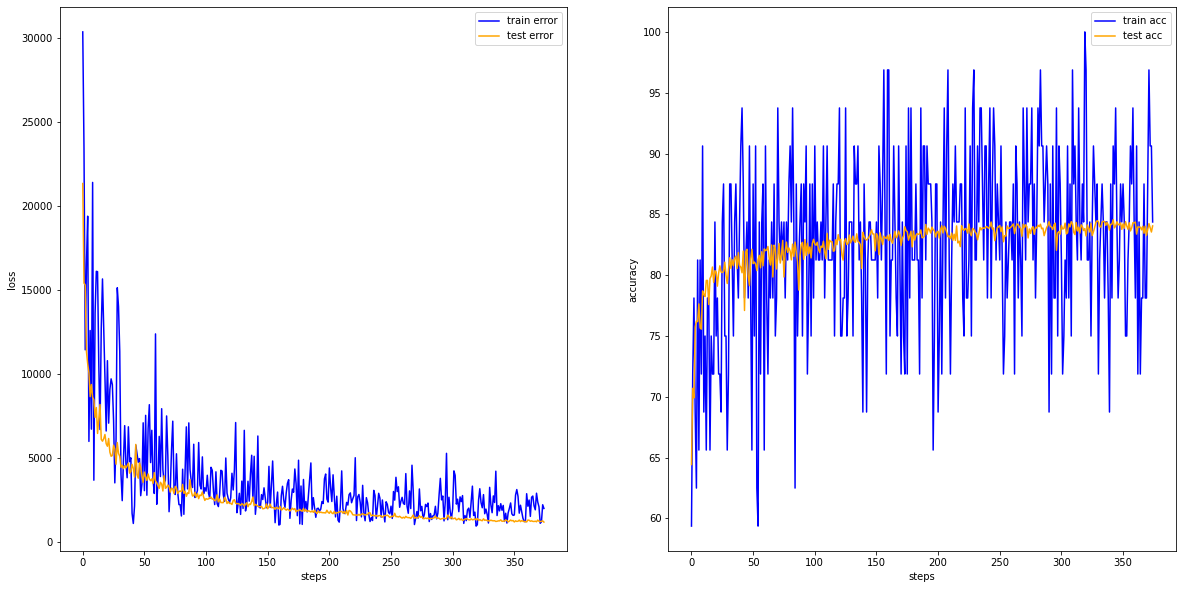

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))
axs[0].plot(train_losses, label="train error", color='blue')
axs[0].plot(eval_losses, label="test error", color='orange')
axs[0].set_xlabel("steps")
axs[0].set_ylabel("loss")
axs[0].legend(loc="upper right")

axs[1].plot(train_accuracy, label="train acc", color="blue")
axs[1].plot(test_accuracy, label="test acc", color='orange')
axs[1].set_xlabel("steps")
axs[1].set_ylabel("accuracy")
axs[1].legend(loc="upper right")

plt.show()

reporting variance

In [ ]:
hidden_size = 1024
learning_rate = 1e-5
batch_size = 32
epochs = 20
dropout = 0.1
beta = 0.001

test_accuracys = []
for i in range(3, 13):
    tf.random.set_seed(i)

    mlp = MLP(input_size, output_size, hidden_size)
    mlp, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = batch_size, 
            learning_rate = learning_rate, 
            epochs = epochs,
            dropout_rate = dropout,
            beta = beta)

    test_acc = test(mlp, x_test_tf, y_test_tf)
    test_accuracys.append(test_acc)

Epoch=1, Steps=100 - Average Train Loss:=12004.1376953125, Average Evaluation Loss:=22634.111328125, Train Batch Acc:=68.75, Evaluation Acc:=65.36
Epoch=1, Steps=200 - Average Train Loss:=16216.70703125, Average Evaluation Loss:=13929.41796875, Train Batch Acc:=62.5, Evaluation Acc:=72.11999999999999
Epoch=1, Steps=300 - Average Train Loss:=14234.037109375, Average Evaluation Loss:=13361.955078125, Train Batch Acc:=75.0, Evaluation Acc:=72.78
Epoch=1, Steps=400 - Average Train Loss:=12856.5517578125, Average Evaluation Loss:=16233.91015625, Train Batch Acc:=68.75, Evaluation Acc:=71.38
Epoch=1, Steps=500 - Average Train Loss:=18494.4140625, Average Evaluation Loss:=12535.9990234375, Train Batch Acc:=50.0, Evaluation Acc:=72.57000000000001
Epoch=1, Steps=600 - Average Train Loss:=13971.9599609375, Average Evaluation Loss:=11610.361328125, Train Batch Acc:=62.5, Evaluation Acc:=73.61999999999999
Epoch=1, Steps=700 - Average Train Loss:=13511.20703125, Average Evaluation Loss:=8807.485351

the mean of 10 runs is 84.30699999999999, and the variance is 0.1417609999999993


{'boxes': [<matplotlib.lines.Line2D at 0x7ff97a650b10>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff97a651b90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff97a655bd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff97a655690>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff97a650e90>,
  <matplotlib.lines.Line2D at 0x7ff97a650e10>]}

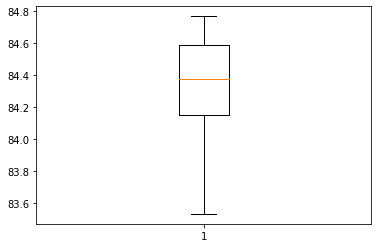

In [ ]:
mean = np.mean(test_accuracys)
var = np.var(test_accuracys)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

plt.boxplot(test_accuracys)